# Predicting with GeoSAM

## Summary

In this chapter we build a workflow for converting our image data to geotiff files usable by geosam.\
Then, we evaluate the performance of geosam to determine its feasibility for the segmentation task.

In [156]:
import numpy as np
import os.path

import math
import pyproj
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

import scipy.io
from osgeo import gdal
from osgeo import osr
from skimage.filters import scharr
from skimage.exposure import equalize_hist

# If running on colab:
# import sys
# sys.path.insert(1, 'elwha_dataset_realignment/book/chapters')
import util

This is useful if you are making changes to `util` and don't want to restard the kernel.

In [157]:
import importlib
importlib.reload(util)

<module 'util' from 'c:\\Users\\stodo\\Desktop\\GeoSMART\\water-surf\\book\\chapters\\util.py'>

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [158]:
# We only use this running locally, since this data file is too big for Github.
# airborne_data_path = "../data/Elwha2012.mat"
# If you are running on colab, use this instead:
# airborne_data_path = "elwha_dataset_realignment/book/data/Elwha2012Mini.mat"
# For just using the mini dataset locally:
airborne_data_path = "../data/Elwha2012Mini.mat"

assert os.path.exists(airborne_data_path)
airborne_data = scipy.io.loadmat(airborne_data_path)
util.initializeFolders()

airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'imageRGB', 'imageIR', 'northings', 'eastings', 'altitude']


Let's take a look at the keys.

In [159]:
class color:
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    END = "\033[0m"

def peekAtData(index: int):
    key = airborne_keys[index]
    data = airborne_data[key]

    print(color.BOLD + color.GREEN + ">", key + color.END)
    print(type(data))
    print(data.shape, "\n")

    return data

In [160]:
rgb_data = peekAtData(3)
ir_data = peekAtData(4)
northings_data = peekAtData(5)
eastings_data = peekAtData(6)
altitude_data = peekAtData(7)

> imageRGB
<class 'numpy.ndarray'>
(640, 480, 25, 3) 

> imageIR
<class 'numpy.ndarray'>
(480, 640, 25) 

> northings
<class 'numpy.ndarray'>
(406, 1) 

> eastings
<class 'numpy.ndarray'>
(406, 1) 

> altitude
<class 'numpy.ndarray'>
(406, 1) 



In [161]:
def convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere=True):
    """
    Convert UTM coordinates (easting, northing) to latitude and longitude.

    Args:
        easting (float): Easting coordinate in meters.
        northing (float): Northing coordinate in meters.
        zone_number (int): UTM zone number (e.g., 33 for UTM Zone 33N).
        northern_hemisphere (bool): True for northern hemisphere, False for southern.

    Returns:
        (float, float): Latitude and Longitude in decimal degrees.
    """
    # Define the UTM projection based on the given zone number and hemisphere
    utm_crs = f"+proj=utm +zone={zone_number} {'+north' if northern_hemisphere else '+south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    
    # Create a transformer from UTM to WGS84 (latitude and longitude)
    transformer = pyproj.Transformer.from_crs(utm_crs, "+proj=longlat +datum=WGS84", always_xy=True)
    
    # Perform the transformation
    lon, lat = transformer.transform(easting, northing)

    return lat, lon

In [162]:
def calculate_image_corners(image_width, image_height, camera_latitude, camera_longitude, camera_altitude):
    # Earth's radius in meters
    earth_radius = 6371000  # approximate value for Earth's mean radius

    # Convert camera latitude and longitude to radians
    camera_lat_rad = math.radians(camera_latitude)
    camera_lon_rad = math.radians(camera_longitude)

    # Calculate the distance from the camera to the Earth's center
    distance_to_center = earth_radius + camera_altitude

    # Calculate the horizontal and vertical field of view angles
    horizontal_fov = 2.0 * math.atan((image_width / 2.0) / distance_to_center)
    vertical_fov = 2.0 * math.atan((image_height / 2.0) / distance_to_center)

    # Calculate the half-width and half-height of the image in meters
    half_width = distance_to_center * math.tan(horizontal_fov / 2.0)
    half_height = distance_to_center * math.tan(vertical_fov / 2.0)

    # Calculate the coordinates of each corner
    top_left_lat = math.degrees(camera_lat_rad + half_height / earth_radius)
    top_left_lon = math.degrees(camera_lon_rad - half_width / earth_radius)

    # top_right_lat = math.degrees(camera_lat_rad + half_height / earth_radius)
    top_right_lon = math.degrees(camera_lon_rad + half_width / earth_radius)

    bottom_left_lat = math.degrees(camera_lat_rad - half_height / earth_radius)
    # bottom_left_lon = math.degrees(camera_lon_rad - half_width / earth_radius)

    # bottom_right_lat = math.degrees(camera_lat_rad - half_height / earth_radius)
    # bottom_right_lon = math.degrees(camera_lon_rad + half_width / earth_radius)

    min_lat = min(top_left_lat, bottom_left_lat)
    min_lon = min(top_left_lon, top_right_lon)
    max_lat = max(top_left_lat, bottom_left_lat)
    max_lon = max(top_left_lon, top_right_lon)

    return [min_lat, min_lon, max_lat, max_lon]

In [163]:
# Example usage, testing Seattle
easting = 549967.97
northing = 5272948.10
zone_number = 10 # UTM zone for west coast is 10
northern_hemisphere = True

latitude, longitude = convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere)
print(f"Latitude: {latitude}, Longitude: {longitude}")

Latitude: 47.60801296515217, Longitude: -122.33516697208582


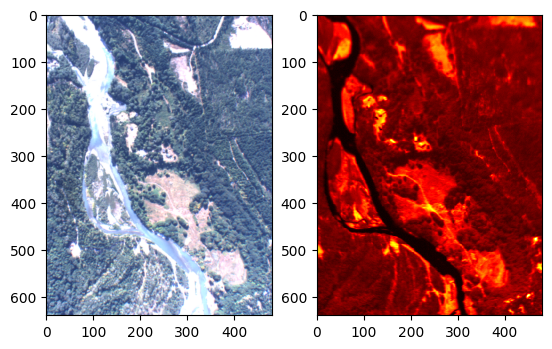

In [164]:
image_index = 11
rgb_image = rgb_data[:,:,image_index]
ir_image = np.rot90(ir_data[:,:,image_index], -1, (0, 1))
image_size = rgb_image.shape[:2]

figure, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(rgb_image)
ax1.imshow(ir_image, interpolation="none", cmap="hot")

In [165]:
#  Setting the geographic transform

easting = eastings_data[image_index]
northing = northings_data[image_index]
zone_number = 10 # UTM zone for west coast is 10
northern_hemisphere = True

lat_center, lon_center = convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere)
print(f"Latitude: {lat_center}, Longitude: {lon_center}") # If we test on https://www.gps-coordinates.net/ these values are accurate

# Example usage:
image_height = image_size[0]
image_width = image_size[1]
camera_altitude = altitude_data[image_index]

loc_corners = calculate_image_corners(image_width, image_height, lat_center[0], lon_center[0], camera_altitude[0])
print(loc_corners)

Latitude: [48.12585801], Longitude: [-123.55441773]
[48.12298018106875, -123.55657609984206, 48.12873583934663, -123.55225935613366]


In [166]:
def create_geotiff_from_png(filename: str, corners, bands) -> str:
  # set geotransform
  nx = image_size[0]
  ny = image_size[1]
  # xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
  xmin, ymin, xmax, ymax = corners
  xres = (xmax - xmin) / float(nx)
  yres = (ymax - ymin) / float(ny)
  geotransform = (xmin, xres, 0, ymax, 0, -yres)

  # create the 3-band raster file
  savepath = util.getSavePath("GEOTIFF", filename)
  dst_ds = gdal.GetDriverByName("GTiff").Create(savepath, ny, nx, len(bands), gdal.GDT_Byte)

  dst_ds.SetGeoTransform(geotransform)    # specify coords
  srs = osr.SpatialReference()            # establish encoding
  srs.ImportFromEPSG(3857)                # WGS84 lat/long
  dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file

  # write each band to the raster
  for idx, band in enumerate(bands):
    dst_ds.GetRasterBand(idx + 1).WriteArray(band)
  
  dst_ds.FlushCache() # write to disk
  dst_ds = None
  
  print(f"Saved {len(bands)} band image to \"{savepath}\"")
  return savepath

In [167]:
r_pixels = rgb_image[:,:,0]
g_pixels = rgb_image[:,:,1]
b_pixels = rgb_image[:,:,2]
rgb_tiff = create_geotiff_from_png("rgb", loc_corners, [r_pixels, g_pixels, b_pixels])

empty_pixels = np.zeros_like(ir_image)
ir_tiff = create_geotiff_from_png("ir", loc_corners, [ir_image, empty_pixels, empty_pixels])

Saved 3 band image to "../out/geotiff/tiff_rgb.tiff"
Saved 3 band image to "../out/geotiff/tiff_ir.tiff"


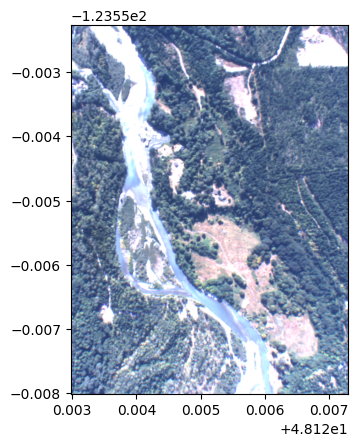

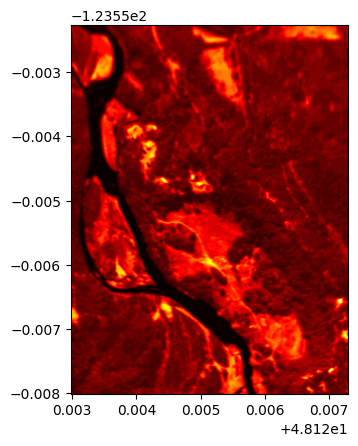

In [168]:
with rasterio.open(rgb_tiff) as ds:
  geotiff_img = ds.read([1, 2, 3])
  show(geotiff_img, transform=ds.profile["transform"])

with rasterio.open(ir_tiff) as ds:
  geotiff_img = ds.read([1])
  show(geotiff_img, transform=ds.profile["transform"], cmap="hot")

# show(scharr(ir_image), transform=ds.profile["transform"])
# show(ir_image, transform=ds.profile["transform"])
# show(equalize_hist(ir_image), transform=ds.profile["transform"])

In [169]:
from samgeo import SamGeo
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

In [170]:
import geopandas
from shapely.geometry import Point

def prediction_prepare(predict_target):
  predict_image = util.getSavePath("GEOTIFF", predict_target)
  sam.set_image(predict_image)

def do_prediction(predict_target, predict_coords, single_band = False):
  predict_image = util.getSavePath("GEOTIFF", predict_target)
  prediction_mask = util.getSavePath("GEOSAM", predict_target)
  sam.predict(predict_coords, point_labels=1, point_crs="EPSG:3857", output=prediction_mask)

  point_coords = [Point(coord) for coord in predict_coords]
  gdf = geopandas.GeoDataFrame(list(range(1, len(predict_coords) + 1)), geometry=point_coords, crs=3857)
  # gdf = gdf.set_crs("epsg:3857")

  figure, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)

  with rasterio.open(predict_image) as src:
    # transform rasterio plot to real world coords
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax0 = rasterio.plot.show(src.read([1]) if single_band else src, extent=extent, ax=ax0, cmap="hot")

    point_color = "blue" if single_band else "red"
    gdf.plot(ax=ax0, color=point_color)

  with rasterio.open(prediction_mask) as ds:
    ax1 = rasterio.plot.show(ds, transform=ds.profile["transform"], ax=ax1)
    # gdf.plot(ax=ax1, color="red")

In [171]:
prediction_prepare("rgb")

c:\Users\stodo\anaconda3\envs\elwha_env\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


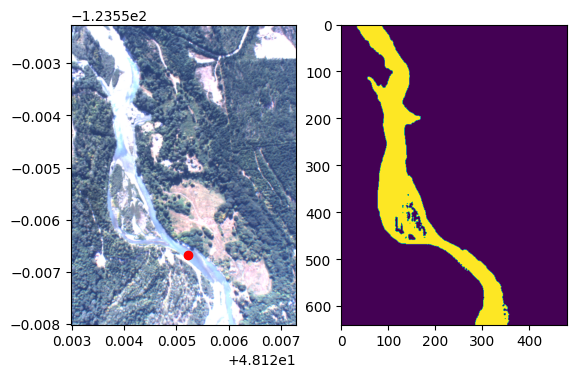

In [172]:
predict_coords = [
  [48.125218010207686, -123.55667772798785],
]

do_prediction("rgb", predict_coords)

In [173]:
prediction_prepare("ir")

c:\Users\stodo\anaconda3\envs\elwha_env\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


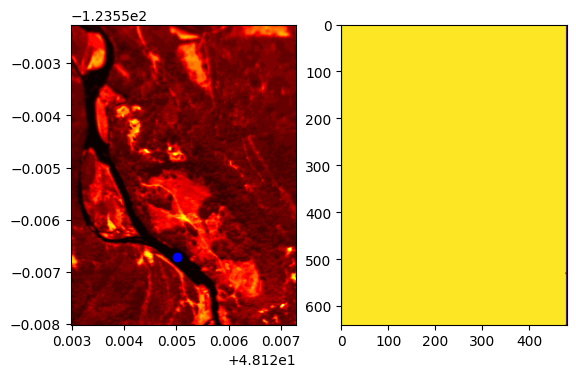

In [174]:
predict_coords = [
  [48.125018010207686, -123.55671772798785],
]

do_prediction("ir", predict_coords, True)